<a href="https://colab.research.google.com/github/negocia438/OC_P7/blob/main/MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Projet 7 - Implémentez un modèle de scoring


##Contexte

Entreprise: "Pret à dépenser" qui Propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt

### 1. Création d'un “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé



Importance de la transparance (souhait des clients + valeurs de l'entreprise)
Dashboard interactif: Pour pouvoir expliquer de façon la plus transparente possible les décisions d’octroi de crédit
Permet aussi à leurs clients de disposer de leurs informations personnelles et de les explorer facilement

### 2. Construire un modèle de scoring qui donnera une prédiction (classification) sur la probabilité de faillite d'un client de façon automatique
Construire un dashboard interactif permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client

### 3. Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions
Utiliser des kernels Kaggle (optionel) pour faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring

Spécifications du dashbord

Visualiser le score et l’interprétation de ce score pour chaque client de façon clair et simple
Visualiser des informations descriptives relatives à un client (via un système de filtre)
Comparer les informations descriptives d'un client à un groupe de clients similaires
Partie technique
Dahboard interactif: Dash OU Bokeh OU Streamlit

Elaborer une plateforme MLOps: https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P7/Outils+Open+Source+MLOps.pdf


Librairie evidently pour détecter du Data Drift en production

Hypothèse: “application_train” = datas pour la modélisation ET “application_test” = datas de nouveaux clients
Créer un tableau HTML pour illustrer ce data drift
Déploiement de l'application dashboard et de l’API: Plateforme Cloud (gratuit), plusieurs choix s'offrent à nous:

Azure webapp (ASP F1 gratuit)
PythonAnywhere
Heroku avec le package “student” de Github
Effectuer de la Cross-Validation

Si les scores scores AUC sont supérieurs à 0.82, le modèle possède probablement de l’overfitting

Création d'une note technique: Présentera l’élaboration du modèle jusqu’à l’analyse du Data Drift

Conseils sur l'elaboration du modèle
Prendre en compte le déséquilibre entre le nombre de bons et de moins bons clients (utiliser une méthode au choix)

Prendre en compte le déséquilibre du coût métier entre entre un faux négatif et un faux positif:

Faux négatif: mauvais client prédit bon client : donc crédit accordé et perte en capital
Faux positif: Bon client prédit mauvais : donc refus crédit et manque à gagner en marge
Hypothèse: le coût d’un FN est dix fois supérieur au coût d’un FP
Création d'un score "métier": Minimisation du coût d’erreur de prédiction des FN et FP

Ce score permet de choisir le meilleur modèle et ses meilleurs hyperparamètres
Attention: Minimisation score métier -> optimisation du seuil qui détermine, la classe 0 ou 1
Un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum
Utiliser aussi l'ACU et l'accuracy pour affiner notre modèle et ses hyperparamètres

Livrable
Application de dashboard interactif + l’API de prédiction du score, déployées chacunes sur le cloud.
Un dossier, géré via un outil de versioning de code contenant:
Notebook de la modélisation (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles
Le code générant le dashboard
Le code permettant de déployer le modèle sous forme d'API
Un fichier permettant de comprendre l'objectif du projet et le découpage des dossiers
Un fichier listant les packages utilisés
Tableau HTML d’analyse de data drift réalisé à partir d’evidently
Une note méthodologique (PDF?) décrivant:
La méthodologie d'entraînement du modèle (2 pages maximum)
Le traitement du déséquilibre des classes (1 page maximum)
La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
Un tableau de synthèse des résultats (1 page maximum)
L’interprétabilité globale et locale du modèle (1 page maximum)
Les limites et les améliorations possibles (1 page maximum)
L’analyse du Data Drift (1 page maximum)
Un support de présentation pour la soutenance (Powerpoint)
Copies écran des commits, du dossier Github (+ lien vers ce dossier) et de l’exécution des tests unitaires
Ce sont les preuves qu’un pipeline de déploiement continu a permis de déployer l’API, doivent être formalisés dans ce support de présentation


# Imports et configurations

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


df = pd.read_csv('/content/drive/MyDrive/Projet 7 - OC/df.csv', sep = ",")
print(df.shape)
df.head()

(356251, 773)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,O

In [3]:
definition_colonnes = pd.read_csv('/content/drive/MyDrive/Projet 7 - OC/HomeCredit_columns_description.csv', encoding='ISO-8859-1')
definition_colonnes[definition_colonnes["Row"] == "TARGET"]

,Unnamed: 0,Table,Row,Description,Special
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN


- TARGET = 1 -> Client avec des difficultés de payments
- TARGET = 0 -> Client sans difficultés de payments

# 1. Déséquilibre entre le nombre de bons et de moins bons clients

Nombre de 0: 282682
Nombre de 1: 24825


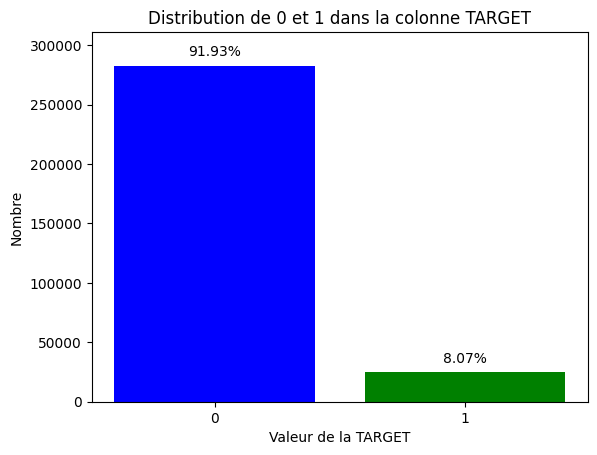

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_target_distribution(df, target_column='TARGET'):
    """
    Affiche la distribution des valeurs 0 et 1 d'une colonne cible sous forme de graphique à barres.

    :param df: DataFrame contenant les données.
    :param target_column: Nom de la colonne cible.
    """
    # Suppression des valeurs NaN
    target_clean = df[target_column].dropna()

    # Comptage des occurrences de chaque valeur
    value_counts = target_clean.value_counts()

    # Extraction des valeurs 0 et 1
    nb_0 = value_counts.get(0, 0)
    nb_1 = value_counts.get(1, 0)

    # Affichage des résultats
    print(f"Nombre de 0: {nb_0}")
    print(f"Nombre de 1: {nb_1}")

    # Calcul des pourcentages
    total = len(target_clean)
    percentages = [(nb_0 / total) * 100, (nb_1 / total) * 100]

    # Création du graphique
    labels = ['0', '1']
    values = [nb_0, nb_1]
    bars = plt.bar(labels, values, color=['blue', 'green'])

    # Ajustement de l'affichage
    plt.ylim(0, max(values) * 1.1)  # 10% d'espace en haut

    # Ajout des annotations
    for bar, pct in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.02 * max(values),
                 f'{pct:.2f}%',
                 ha='center',
                 va='bottom')

    plt.xlabel('Valeur de la TARGET')
    plt.ylabel('Nombre')
    plt.title('Distribution de 0 et 1 dans la colonne TARGET')
    plt.show()


plot_target_distribution(df)